# Finance using NLTK and Random Forest by [eestra2](https://github.com/eestra2)

### An introductory walk-through of using code and machine learning modules for financial programming.

#### Note: 
#### Not geared towards the general audience. This walk-through assumes some basic Python knowledge, finance principles, and  general statistics.  Also this is toy data and modeling, far from perfect in every sense. The goal is to get people with finance/economics background, with amateur coding abilities, get their hands wet with python programming. The aim is to understand what is going on with the coding part (where most business majors lack in) line by line in order to show where everything is coming from and not seem like code is magic. This is not a foremost showcase of the optimal fine-tuned model predicting highly accurate stock prices. This is not the ideal starting point for someone who is starting to program for the first time. Think of this as a good place to step out of the basics of Python programming and start  something that is "beginner to mid-level transition". 


## Table of Contents

1. <a href="#1.-DJIA-Prediction-with-Sentiment-Analysis">DJIA Prediction with Sentiment Analysis</a>
2. <a href="#2.-Data-Prep">Data Prep</a>
3. <a href="#3.-Natural-Language-Processing">Natural Language Processing</a>
4. <a href="#4.-Split/Test/Train-Data-Sets">Split/Test/Train Data Sets</a>
5. <a href="#5.-Random-Forest-Training">Random Forest Training</a>
6. <a href="#6.-Predict-and-Break-Down">Predict and Break Down<a/>
7. <a href="#7.-Graphing">Graphing<a/>
8. <a href="#8.-Conclusion-&-Final-Thoughts">Conclusion and Final Thoughts<a/>

# 1. DJIA Prediction with Sentiment Analysis

In this tutorial I will be using model Random Forest to predict Dow Jones Index. Besides historical prices, I also want to include sentimental analysis features that can contribute to the way a stock price might move. For example, if there is negative news about a company not meeting its expected earnings, stock price for that company will certainly dip. On the other hand, if good news is reported to the public about a company surpassing expected earnings, the price of that company will most likely increase as investors scramble to bid for more shares of that company. Market sentiment plays a huge role in the short-term in equity markets, dictating the way prices move. Thus, I find it crucial to attempt to map media sentiment to stock price movement; however, I will be using the Dow Jones Industrial Average as a proxy to how the stock market moves in response to news. Dow Jones is a price-weighted index that contains 30 largest American companies that approximates the American economy. One quick take away of the Dow is that it is price-weighted. Companies in the Dow index with the highest stock prices will influence the overall index more so than others with lower stock prices. Dow Jones is the oldest and most quoted index in the world

# 2. Data Prep

[<a href="#Finance-using-NLTK-and-Random-Forest-by-eestra2">Back to top</a>]

In [1]:
# Dependencies 

import numpy as np
import pandas as pd

In [2]:
# To concentrate on the modeling process rather than spending too much time on data aquisition through APIs, that tend to be a hassle at times, 
# I have included a pickle file that contains the clean data of the Dow Jones Industrial Average index and news articles for the sentiment analysis part. 

df_stocks = pd.read_pickle('cleaned_data.pkl')

In [3]:
# Here we check if everything went smoothly; you should get columns...."close", "adj close", "articles"

df_stocks.head()

,close,adj close,articles
2007-01-01,12469.971875,12469.971875,. What Sticks from '06. Somalia Orders Islamis...
2007-01-02,12472.245703,12472.245703,. Heart Health: Vitamin Does Not Prevent Death...
2007-01-03,12474.519531,12474.519531,. Google Answer to Filling Jobs Is an Algorith...
2007-01-04,12480.690430,12480.690430,. Helping Make the Shift From Combat to Commer...
2007-01-05,12398.009766,12398.009766,. Rise in Ethanol Raises Concerns About Corn a...


In [4]:
# Now we make some minor adjustments by making sure the adj close column contains integers and not string-numbers. 
# Apply() function to apply another numpy attribute to convert column to integers.
# And also we place the new data type into a new column called "prices"

df_stocks['prices'] = df_stocks['adj close'].apply(np.int64)

In [5]:
# Extract the prices and articles columns and assign it to the same variable to overwrite the previous dataframe.
df_stocks = df_stocks[['prices', 'articles']]

In [6]:
# Double check we have two columns: prices and articles. 

df_stocks.head()

,prices,articles
2007-01-01,12469,. What Sticks from '06. Somalia Orders Islamis...
2007-01-02,12472,. Heart Health: Vitamin Does Not Prevent Death...
2007-01-03,12474,. Google Answer to Filling Jobs Is an Algorith...
2007-01-04,12480,. Helping Make the Shift From Combat to Commer...
2007-01-05,12398,. Rise in Ethanol Raises Concerns About Corn a...


In [7]:
# Apply map() function to each element in the articles column to get rid of the unnecessary characters ".-"

df_stocks['articles'] = df_stocks['articles'].map(lambda x: x.lstrip('.-'))

In [8]:
# Confirm it went through

df_stocks.head()

,prices,articles
2007-01-01,12469,What Sticks from '06. Somalia Orders Islamist...
2007-01-02,12472,Heart Health: Vitamin Does Not Prevent Death ...
2007-01-03,12474,Google Answer to Filling Jobs Is an Algorithm...
2007-01-04,12480,Helping Make the Shift From Combat to Commerc...
2007-01-05,12398,Rise in Ethanol Raises Concerns About Corn as...


In [9]:
# Now we're ready to extract prices column again to place it in another dataframe.

df = df_stocks[['prices']].copy()
df.head()

,prices
2007-01-01,12469
2007-01-02,12472
2007-01-03,12474
2007-01-04,12480
2007-01-05,12398


In [10]:
# Add empty columns with labels to the dataframe df to prep it for incoming sentiment values.
df["compound"] = ''
df["neg"] = ''
df["neu"] = ''
df["pos"] = ''

In [11]:
# And here we have it...all ready to go!

df.head()

,prices,compound,neg,neu,pos
2007-01-01,12469,,,,
2007-01-02,12472,,,,
2007-01-03,12474,,,,
2007-01-04,12480,,,,
2007-01-05,12398,,,,


[<a href="#Finance-using-NLTK-and-Random-Forest-by-eestra2">Back to top</a>]

# 3. Natural Language Processing

Here the coding can be cryptic and confusing for most beginners. From the NLTK library, we can use its SentimentIntensityAnalyzer() to weigh text (called the intensity) and the sentiment of it being either positve, negative, or neutral (the polarity). 

Compound values are computed by taking all textual sentiment as a whole into consideration and then its weighted on a scale of -1(extremely negative) to 1(extremely positive). The rest of the columns break down the article text and measure the proportion of text being negative, positive, and neutral. As a result, you can sum up their values across and you will get 1.

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

sid = SentimentIntensityAnalyzer()

for date, row in df_stocks.T.iteritems():
    try:
        sentence = unicodedata.normalize('NFKD', df_stocks.loc[date, 'articles'])
        ss = sid.polarity_scores(sentence)
        df.at[date, 'compound'] = ss['compound']
        df.at[date, 'neg'] = ss['neg']
        df.at[date, 'neu'] = ss['neu']
        df.at[date, 'pos'] = ss['pos']
    except TypeError:
        print(df_stocks.loc[date, 'articles'])
        print(date)

In [13]:
# We have our sentiment values populate our df dataframe

df.head()

,prices,compound,neg,neu,pos
2007-01-01,12469,-0.9735,0.153,0.748,0.099
2007-01-02,12472,-0.9702,0.122,0.786,0.092
2007-01-03,12474,-0.9994,0.203,0.736,0.06
2007-01-04,12480,-0.9982,0.131,0.806,0.062
2007-01-05,12398,-0.9901,0.124,0.794,0.082


[<a href="#Finance-using-NLTK-and-Random-Forest-by-eestra2">Back to top</a>]

## 4. Split/Test/Train Data Sets

In [14]:
# Split some of the data into training set and test set
# The earlier dates will be selected to train the model and the latter dates will be the test set that we want to target (predict).
# It serves to measure against the model's predictions to measure accuracy. 

train_start_date = '2007-01-01'
train_end_date = '2014-12-31'
test_start_date = '2015-01-01'
test_end_date = '2016-12-31'
train = df.loc[train_start_date : train_end_date]
test = df.loc[test_start_date:test_end_date]

In [15]:
# We extract from the train dataset the values of "neg" and "pos" from each date 
# to be converted into numpy arrays within a numpy array (for more info on train.T.iteritems usage see appendix)
# essentially, a matrix. Matrices are the magic of how most models compute.  

sentiment_score_list = []

for date, row in train.T.iteritems():
    sentiment_score = np.asarray([df.loc[date, 'neg'],df.loc[date, 'pos']])
    sentiment_score_list.append(sentiment_score)

numpy_df_train = np.asarray(sentiment_score_list)

In [16]:
numpy_df_train

array([[ 0.153,  0.099],
       [ 0.122,  0.092],
       [ 0.203,  0.06 ],
       ..., 
       [ 0.171,  0.075],
       [ 0.16 ,  0.14 ],
       [ 0.198,  0.135]])

In [17]:
# The same goes for the testing set

sentiment_score_list = []

for date, row in test.T.iteritems():
    sentiment_score = np.asarray([df.loc[date, 'neg'],df.loc[date, 'pos']])
    sentiment_score_list.append(sentiment_score)

numpy_df_test = np.asarray(sentiment_score_list)

In [18]:
numpy_df_test

array([[ 0.138,  0.122],
       [ 0.149,  0.093],
       [ 0.131,  0.083],
       ..., 
       [ 0.138,  0.097],
       [ 0.173,  0.094],
       [ 0.173,  0.161]])

In [19]:
# Create a seperate train and test sub-sets from values of column "prices"
# Remember, we want to train the model to map features(predictors) to the corresponding prices (target).

y_train = pd.DataFrame(train['prices'])
y_test = pd.DataFrame(test['prices'])

[<a href="#Finance-using-NLTK-and-Random-Forest-by-eestra2">Back to top</a>]

# 5. Random Forest Training

In [20]:
# Now its time to get down to business by finally training the model, Random Forest.

# import ML models from scikit-learn module
# treeinterpreter is a supporting package of scikit-learn that allows interpretation of the prediction results of the model to be
# broken-down to its components of features that contributed and a bias constant. 

from treeinterpreter import treeinterpreter as ti
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor()

rf.fit(numpy_df_train, y_train)

C:\Users\eestra2\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [21]:
# Displays the percentage contribution of the negative and positive features in the learning process; looks almost equal with negative contributing slightly more.
# It is expected as if you look back at the dataframe df, you will see that neg column for the most part was higher in percentage than positive.

rf.feature_importances_

array([ 0.55307151,  0.44692849])

[<a href="#Finance-using-NLTK-and-Random-Forest-by-eestra2">Back to top</a>]

# 6. Predict and Break Down

In [22]:
# Predict and break down the Random Forest results into components using the tree interpreter

prediction, bias, contributions = ti.predict(rf, numpy_df_test)

In [23]:
# These are the predicted prices given the test set of sentiment values

prediction

array([ 13830.7       ,  13156.275     ,  10860.9       ,  13526.        ,
        10523.7       ,  15231.04166667,  12643.7       ,  12342.1       ,
        12981.5       ,  16155.1       ,  11832.        ,  12342.3       ,
        10259.98      ,  13681.5       ,  12925.        ,  13484.93333333,
         9981.4       ,  11702.18333333,   9350.9       ,  10957.6       ,
        11949.3       ,  12897.8       ,  11735.2       ,  10192.6       ,
        13378.2       ,  11991.6       ,  12431.1       ,  13353.6       ,
        12814.51666667,  10993.1       ,   9889.18333333,  12903.8       ,
        13796.8       ,  11822.7       ,  12401.70833333,  13338.83333333,
        13541.76666667,  12527.3       ,  10940.3       ,  13671.3       ,
        11314.1       ,  12725.85      ,  14419.5       ,  12665.6       ,
        12064.9       ,  14331.8       ,   9052.11333333,  14567.5       ,
        17061.        ,  11039.08333333,  10989.46666667,  13920.3       ,
        12359.8       ,  

In [24]:
contributions

array([[  246.53832178,   987.34863921],
       [  151.08885348,   408.37310751],
       [  147.50569852, -1883.41873754],
       ..., 
       [  865.91395782, -1062.45199683],
       [ -173.84206946,  -292.67096955],
       [ 1064.73528568,  1064.15167531]])

In [25]:
bias

array([ 12596.81303901,  12596.81303901,  12596.81303901,  12596.81303901,
        12596.81303901,  12596.81303901,  12596.81303901,  12596.81303901,
        12596.81303901,  12596.81303901,  12596.81303901,  12596.81303901,
        12596.81303901,  12596.81303901,  12596.81303901,  12596.81303901,
        12596.81303901,  12596.81303901,  12596.81303901,  12596.81303901,
        12596.81303901,  12596.81303901,  12596.81303901,  12596.81303901,
        12596.81303901,  12596.81303901,  12596.81303901,  12596.81303901,
        12596.81303901,  12596.81303901,  12596.81303901,  12596.81303901,
        12596.81303901,  12596.81303901,  12596.81303901,  12596.81303901,
        12596.81303901,  12596.81303901,  12596.81303901,  12596.81303901,
        12596.81303901,  12596.81303901,  12596.81303901,  12596.81303901,
        12596.81303901,  12596.81303901,  12596.81303901,  12596.81303901,
        12596.81303901,  12596.81303901,  12596.81303901,  12596.81303901,
        12596.81303901,  

[<a href="#Finance-using-NLTK-and-Random-Forest-by-eestra2">Back to top</a>]

# 7. Graphing

In [26]:
# Next, we take a look at the big picture using matplotlib module to display a comparative graph to show
# predicted price vs actual price

import matplotlib.pyplot as plt
%matplotlib inline                    

In [27]:
# Here we make the x-axis of the graph which is the test-start-date to the test-end-date.
# We also extract prediction values from the gigantic array we saw earlier and place it into a dataframe along with corresponding
# dates. 

idx = pd.date_range(test_start_date, test_end_date)
predictions_df = pd.DataFrame(data=prediction[0:], index = idx, columns=['prices'])

In [28]:
predictions_df.head()

,prices
2015-01-01,13830.700
2015-01-02,13156.275
2015-01-03,10860.900
2015-01-04,13526.000
2015-01-05,10523.700


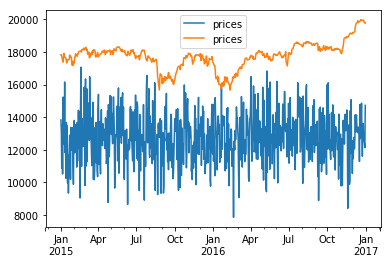

In [29]:
# we plot the above dataframe 
predictions_plot = predictions_df.plot()

# Then we integrate it with the real values that are assigned to variable y_test
fig = y_test.plot(ax = predictions_plot).get_figure()
fig.savefig("random forest non-smoothing.png")

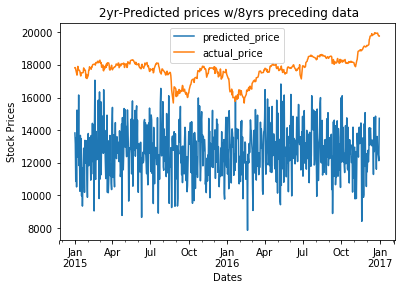

In [31]:
# The above graph is not very well illustrated since we are missing labels.
# So here we add titles and labels to better convey our findings. 


ax = predictions_df.rename(columns={"prices": "predicted_price"}).plot(title=' 2yr-Predicted prices w/8yrs preceding data')
ax.set_xlabel("Dates")
ax.set_ylabel("Stock Prices")
fig = y_test.rename(columns={"prices": "actual_price"}).plot(ax = ax).get_figure()
fig.savefig("random forest non-smoothing.png")


[<a href="#Finance-using-NLTK-and-Random-Forest-by-eestra2">Back to top</a>]

# 8. Conclusion & Final Thoughts

Immediately we see that predicted prices are way off from the actual prices. In addition, we see sharp and deep changes in  predicted prices relative to the actual prices. In order to understand more closely what happened, we need to ask ourselves "what is Random Forest?". Random Forest is a collection of decision trees. Each decision tree comes to a conclusion (prediction) and then they all majority-vote on the final prediction (remember the VotingClassifier in the previous section...this does almost exactly like that). Think of each tree as a unique person going through an extensive chain of decisions, given alternatives and conditions, to reach a conclusion or final prediction. Then we average those results up and we get a Random Forest prediction! So think of it as a pool of people working as a team with each individual incorporating their knowledge and information to solve the problem. Does this sound like a normal distribution of outcomes? Indeed, it is very analogous to a normal distribution where some trees might over shoot by a lot but it will be ultimately countered by more trees shooting around the average or expected value. Also, bear in mind that the more diverse the trees are, the better the prediction as less diverse trees may sway the outcome with bias. Thus, the word "random" in "Random Forest" means that in order to exclude bias in the decision trees, they each get a random sub-set of the features that they will train with. Random training points will ensure the trees are using information that is evenly spread out. 

Now that we have a rough idea how Random Forests work, we can start making inferences on why the large discrepancies. It could be that we need to fine-tune the model itself by adjusting its parameters (for example, number of trees in the model). Another reason could be that price movements are largely dictated by many factors, not just market sentiment. We might be missing other crucial features that the trees need in order to be able to map them to the price (target). Also, bear in mind that prices are a time-series problem. That means that prices are autocorrelated and so previous instances of prices heavily influence the next proceeding price. That being said, the strength of previous instances in time might not have any influence after some time. This means that if were predicting tomorrow's price of something, going back even as far as 1 year in  historical prices might be irrelevant because prices could also be seasonal or cyclical in nature. Thus, we might have to adjust the time interval to something smaller. Quality of the source of data is also extremely important. If you give algorithms garbage data, the results are not going to correctly represent the thing at study. So make sure you know where the data is coming from and assess its validity with respect to the nature of the problem. Finally I want too mention that it could also be the wrong model for the job. Financial studies have shown that in the  short-term, prices are highly random and impossible to predict with accuracy. Perhaps another model that uses probabilities to predict random outcomes is much better suited for this problem. I leave any fine tuning up to you now! Have fun!

Fine Tune Summary
1. Model modifications
2. Features modification
3. Volume of data modification
4. Quality of data (note: quality > quantity)

[<a href="#Finance-using-NLTK-and-Random-Forest-by-eestra2">Back to top</a>]

**There is more to this but decided to keep it simple in order to get beginners started and learn how to think and question every aspect; as opposed to just memorizing answers and procedures which does not contribute to any understanding.**

# Check out my other notebook on simple Neural Network

#### Finance using simple Neural Networks by [eestra2](https://github.com/eestra2)